In [ ]:
!pip install -q datasets transformers evaluate timm albumentations

In [1]:
## Here are the steps that does in this small script:
# - download the roboflow dataset using curl.
# - create a new folder named Data
# - move the roboflow.zip to Data
# - go to the Data directory and unzip the zip file contents
# - remove the roboflow.zip
# - and then come out from the folder 

!curl -L "https://public.roboflow.com/ds/NX0fXQIoN7?key=yPLJgC37Pg" > roboflow.zip \
&& mkdir -p Data \
&& mv roboflow.zip Data/ \
&& cd Data \
&& unzip roboflow.zip \
&& rm roboflow.zip \
&& cd ..

SyntaxError: invalid syntax (1972926456.py, line 6)

In [1]:
# define the relative train and test data path 

train_data_path = 'Data/train'
test_data_path = 'Data/test'

In [2]:
### About the data
## The data we are using is a simple object detection dataset, which lets us to detect whether construction
## workers or wearing helmets or not. 
## This has a huge practical use-case, since we can track the safety of the people working in the construction
## sites in the real time.

### The structure of the data
## Inside the train and the test folder, we have a some bunch of images and and some bunch of .xml files.
# For example, this is how a sample in the folder looks like:
# test/
# ├── 005298_jpg.rf.7d1070e4a462d4c636a68e64f2013761.jpg
# ├── 005298_jpg.rf.7d1070e4a462d4c636a68e64f2013761.xml
# ├── 005299_jpg.rf.a79cacc62cdd99ad871cf1786ad865ff.jpg
# ├── 005299_jpg.rf.a79cacc62cdd99ad871cf1786ad865ff.xml
# So, we are going to parse each of the .xml file and get the all the information about the images and 
# and the annotation in the form of a dict. The dict looks something like this:
# objects = {
#     'id': [],
#     'area': [],
#     'bbox': [],
#     'category': []
# }
# where:
## - id: is class id's of the objects residing in the image
## - area: is the area of the bounding box
## - bbox: is the bounding box (un-normalized)
## - category: the cateory / class of the image 

import os
from xml.etree import ElementTree as ET
from PIL import Image

def parse_xml_file_and_extract_information(xml_file: str, folder: str) -> dict:
    """Parses an xml file (assumed to be defined in Pascal VOC format) and returns information on image
    and annotation.
    
    Args:
        xml_file: (str) The xml file. 
        folder: (str) The folder under which the xml file lies. 
    
    Returns:
        It returns a dictionary. With the following structure.
        {
            'image_id': image_id,
            'image': a PIL image object,
            'width': width of the image,
            'height': height of the image,
            'objects': objects = {
                'id': [],      # the class id of the objects
                'area': [],    # the area of the bounding box
                'bbox': [],    # the bounding box 
                'category': [] # the class category in string 
            }
        }
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_id = int(root.find('filename').text.split('_')[0])
    
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    objects = {
        'id': [],
        'area': [],
        'bbox': [],
        'category': []
    }

    for obj in root.findall('object'):
        obj_name = obj.find('name').text
        try:
            if obj_name == 'head':
                obj_id = 0
            elif obj_name == 'helmet':
                obj_id = 1
            else:
                obj_id = 2

            xmin = float(obj.find('bndbox/xmin').text)
            xmax = float(obj.find('bndbox/xmax').text)
            ymin = float(obj.find('bndbox/ymin').text)
            ymax = float(obj.find('bndbox/ymax').text)

            area = (xmax - xmin) * (ymax - ymin)
            bbox = [xmin, ymin, xmax - xmin, ymax - ymin]

            objects['id'].append(obj_id)
            objects['area'].append(area)
            objects['bbox'].append(bbox)
            objects['category'].append(obj_name)
        except Exception as e:
            continue
    return {
        'image_id': image_id,
        'image': Image.open(os.path.join(folder, root.find('filename').text)),
        'width': width,
        'height': height,
        'objects': objects
    }

In [3]:
sample_file = os.path.join(train_data_path, '000164_jpg.rf.b6dfa5c35cb8bcff5785b7b4e860f2cc.xml')
sample_annotation_dict = parse_xml_file_and_extract_information(
    xml_file=sample_file, folder=train_data_path
)

In [4]:
sample_annotation_dict

{'image_id': 164,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=416x415>,
 'width': 416,
 'height': 416,
 'objects': {'id': [0, 0, 0, 0],
  'area': [1178.0, 750.0, 1638.0, 2080.0],
  'bbox': [[167.0, 133.0, 31.0, 38.0],
   [115.0, 142.0, 25.0, 30.0],
   [335.0, 134.0, 39.0, 42.0],
   [55.0, 131.0, 40.0, 52.0]],
  'category': ['head', 'head', 'head', 'head']}}

In [5]:
## Now that we have created a simple function on how parsing the xml and returning a dict.
## We will use this to parse a whole directory and make a huggingface dataset out of this

from datasets import Dataset
from tqdm.auto import tqdm 

def create_object_detection_data_hf_forrmat(folder_path: str) -> Dataset:
    """Function to parse each of the xml files and creating a HF dataset out of it. 
    
    Args:
        folder_path: (str) The folder path that contains all the xml file inside it. 
    Returns:
        A huggingface Dataset object containing the required annotation and image information.
    """
    data = []
    all_xml_file_paths = [os.path.join(folder_path, xml_file) for xml_file in os.listdir(folder_path)]

    for xml_file in tqdm(all_xml_file_paths, total=len(all_xml_file_paths)):
        if xml_file.endswith('.xml'):
            try:
                with open(xml_file, 'r') as file:
                    data.append(parse_xml_file_and_extract_information(file, folder_path))
            except Exception as e:
                continue

    dataset = Dataset.from_list(data)
    return dataset

In [6]:
# create the train and the test dataset by parsing each of the folder.

train_dataset = create_object_detection_data_hf_forrmat(train_data_path)
test_dataset = create_object_detection_data_hf_forrmat(test_data_path)

  0%|          | 0/10538 [00:00<?, ?it/s]

  0%|          | 0/3532 [00:00<?, ?it/s]

In [7]:
### Now we will draw some random instances of the dataset to just see how the dataset looks like
## this will be achieved by two function. In the first function, we will just draw an image 
## by fetching from an index. And in the second function, we will use this to draw six image, side by side.


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def draw_image_from_idx(dataset, idx: int):
    """
    Takes the idx and draws and annotate that image.
    Returns:
        An image, drawn with a bounding box.
    """
    assert idx <= len(dataset)
    image, annotations = dataset[idx]['image'], dataset[idx]['objects']['category']
    draw = ImageDraw.Draw(image)
    width, height = image.size
    bboxes = train_dataset[idx]['objects']['bbox']
    
    categories = dataset[idx]['objects']['category']

    id2label = {index: x for index, x in enumerate(categories, start=0)}
    label2id = {v:k for k,v in id2label.items()}

    for i in range(len(annotations)):
        box = bboxes[i]
        class_idx = label2id[annotations[i]]
        x,y,w,h = tuple(box)
        if max(box) > 1.0:
            # Coordinates are un-normalized, rescale them
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            # Coordinates are normalized, scale them
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)

        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), id2label[class_idx], fill="white")

    return image

def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = 2
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

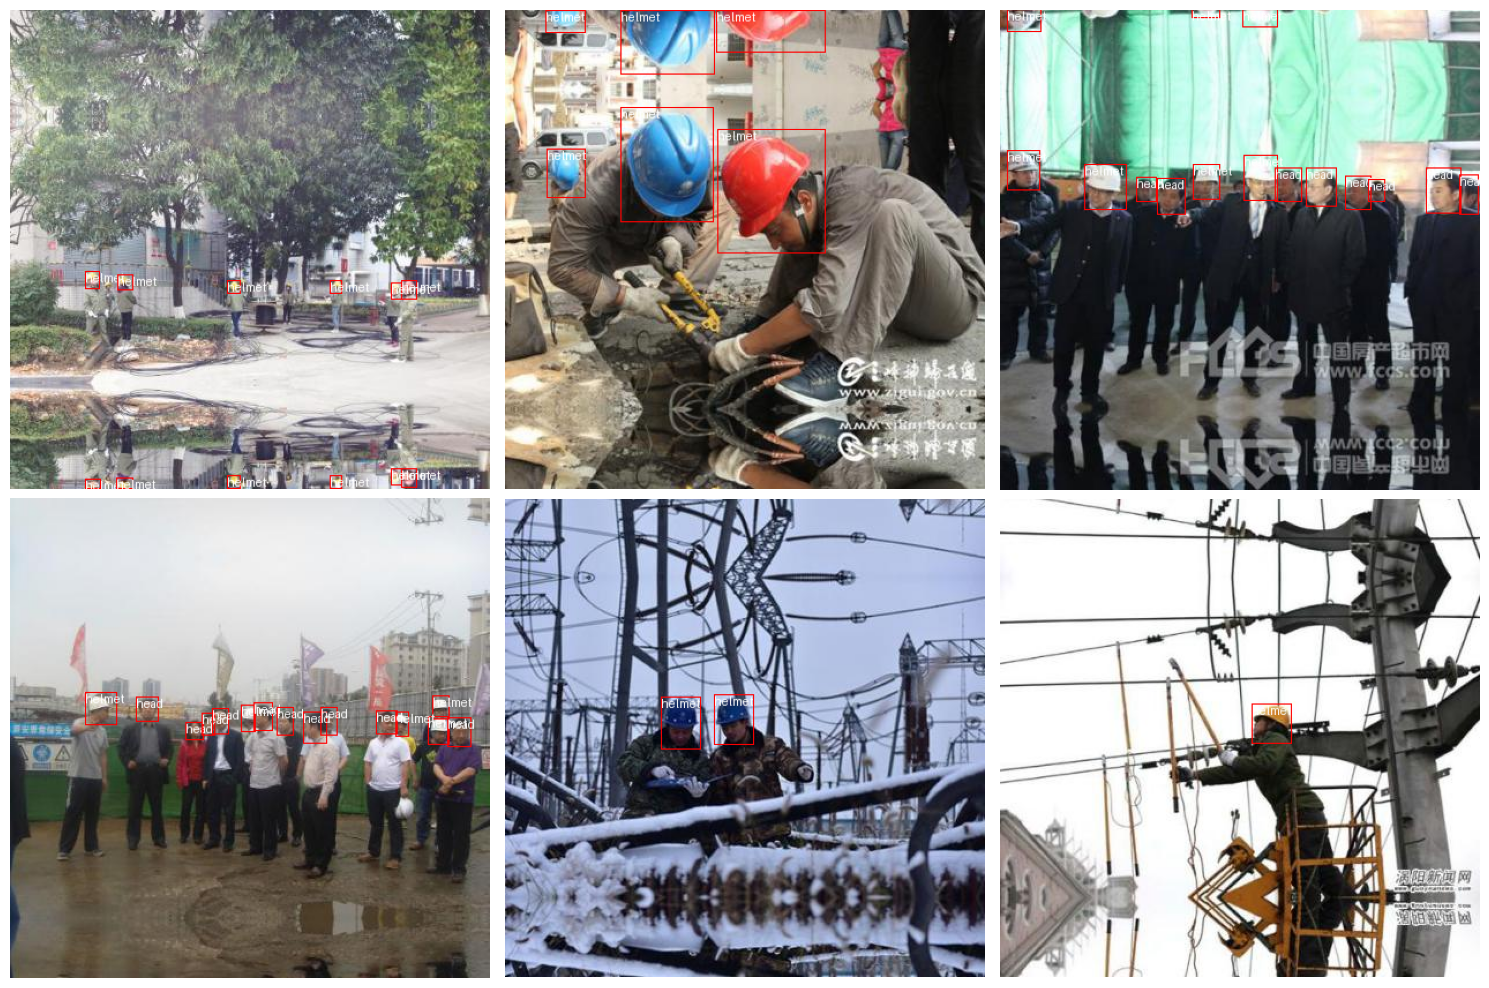

In [8]:
plot_images(train_dataset, range(6))

In [9]:
### Preprocessing the dataset

from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

2023-12-05 01:55:23.201368: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 01:55:23.201405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 01:55:23.201449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 01:55:23.236174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Could not find image processor class in the image 

In [10]:
# now creating random augmentations using albumentations

import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [11]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [12]:
# transforming a batch

def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [13]:
train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)

In [14]:
train_dataset_transformed[0]

{'pixel_values': tensor([[[-0.9534, -0.9192, -0.8849,  ...,  1.4440,  1.4954,  1.5297],
          [-0.9705, -0.9192, -0.8849,  ...,  1.4440,  1.4954,  1.5297],
          [-0.9877, -0.9363, -0.8678,  ...,  1.4612,  1.4954,  1.5297],
          ...,
          [ 0.0398, -0.1143, -0.3541,  ...,  0.3652,  0.2282,  0.1254],
          [ 0.0056, -0.1314, -0.3712,  ...,  0.3138,  0.1768,  0.0741],
          [-0.0116, -0.1486, -0.3712,  ...,  0.2796,  0.1426,  0.0398]],
 
         [[-0.7927, -0.7577, -0.7227,  ...,  1.6232,  1.6758,  1.7108],
          [-0.7927, -0.7577, -0.7227,  ...,  1.6232,  1.6758,  1.7108],
          [-0.8102, -0.7752, -0.7052,  ...,  1.6408,  1.6758,  1.7108],
          ...,
          [ 0.3803,  0.2052, -0.0399,  ...,  0.7654,  0.6254,  0.5203],
          [ 0.3627,  0.1877, -0.0399,  ...,  0.7129,  0.5728,  0.4678],
          [ 0.3452,  0.1877, -0.0399,  ...,  0.6779,  0.5378,  0.4328]],
 
         [[-0.6367, -0.6018, -0.5495,  ...,  1.8905,  1.9428,  1.9777],
          [-

In [15]:
# now create a collate function

def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [16]:
# Now we will be using a transformer model to fine-tune for object detection for our set of defined classes

from transformers import AutoModelForObjectDetection

categories = train_dataset[0]['objects']['category']
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    tokenizer=image_processor,
)

trainer.train()

wandb: Currently logged in as: anindya. Use `wandb login --relogin` to force relogin


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 5.80 GiB total capacity; 5.46 GiB already allocated; 59.69 MiB free; 5.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF